<a href="https://colab.research.google.com/github/twelvesense/first-repository/blob/master/GoCvNode01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로젝트: ResNet Ablation Study

# 1: 사전 준비

## 1.1: 라이브러리

In [4]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import activations
import keras.layers as L
import keras.regularizers as R
import matplotlib.pyplot as plt
import urllib3
urllib3.disable_warnings()

##1.2: 데이터셋

* cats_vs_dogs

In [5]:
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

In [6]:
(ds224_train, ds224_test), ds224_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [7]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds224_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [8]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds224_train))
print(tf.data.experimental.cardinality(ds224_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


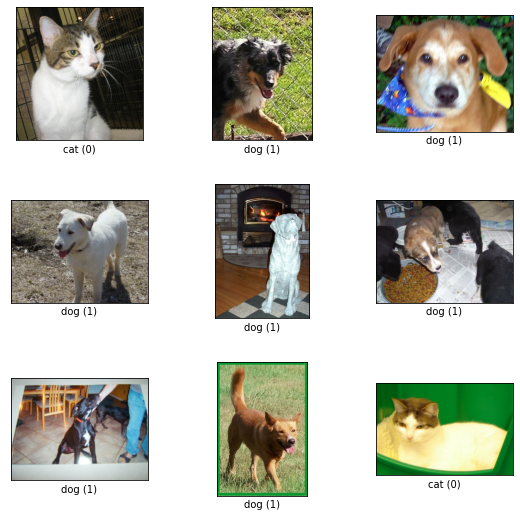

In [9]:
fig = tfds.show_examples(ds224_train, ds224_info)

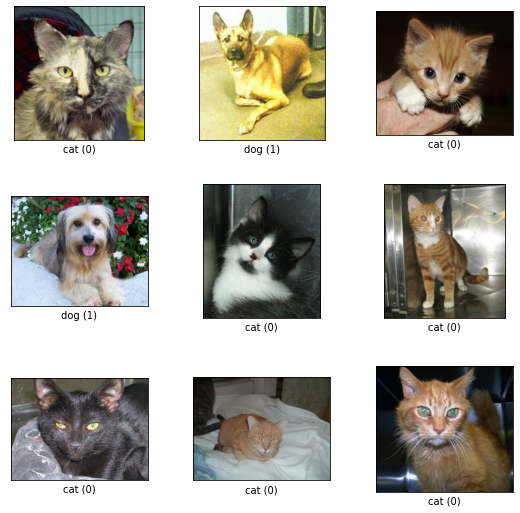

In [21]:
fig = tfds.show_examples(ds224_test, ds224_info)

##1.3: 함수

In [17]:
# def normalize_and_resize_img32(image, label):
def normalize_and_resize_img32(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

# def apply_normalize_on_dataset32(ds, is_test=False, batch_size=16):
def apply_normalize_on_dataset32(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img32, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# def normalize_and_resize_img224(image, label):
def normalize_and_resize_img224(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

# def apply_normalize_on_dataset224(ds, is_test=False, batch_size=16):
def apply_normalize_on_dataset224(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img224, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds    

##1.4: 데이터 전처리

In [11]:
BATCH_SIZE = 256

In [19]:
ds224_train2 = apply_normalize_on_dataset224(ds224_train, batch_size=BATCH_SIZE)
ds224_test2 = apply_normalize_on_dataset224(ds224_test, batch_size=BATCH_SIZE)

#2: ResNet 기본 블록 구성하기

##2.1: identity block

In [20]:
# identity_block
def identity_block(plain, model, x, chs): 
    x_skip = x 

    if model != 34 and model != 50:
        print('error')

    if model == 50:
        x = L.Conv2D(chs, kernel_size=1, strides=1, padding='valid', kernel_regularizer=R.l2(0.001))(x)
        x = L.BatchNormalization()(x)
        x = L.Activation('relu')(x)

    x = L.Conv2D(chs, kernel_size=3, strides=1, padding='same', kernel_regularizer=R.l2(0.001))(x)
    x = L.BatchNormalization()(x)
    x = L.Activation('relu')(x)

    if model == 34:
        x = L.Conv2D(chs, kernel_size=3, strides=1, padding='same', kernel_regularizer=R.l2(0.001))(x)
        x = L.BatchNormalization()(x)

    if model == 50:
        x = L.Conv2D(chs*4, kernel_size=1, strides=1, padding='same', kernel_regularizer=R.l2(0.001))(x)
        x = L.BatchNormalization()(x)

    if plain == 0:
        x = L.Add()([x, x_skip])
    x = L.Activation('relu')(x)

    return x

##2.2: convolutional block

In [21]:
# convolutional_block
def convolutional_block(plain, model, x, chs, first):
    print('x', x)
    x_skip = x

    if model != 34 and model != 50:
        print('error')

    if model == 50:
        if first == 1:
            x = L.Conv2D(chs, kernel_size=1, strides=1, padding='same', kernel_regularizer=R.l2(0.001))(x)
        else:
            x = L.Conv2D(chs, kernel_size=1, strides=2, padding='same', kernel_regularizer=R.l2(0.001))(x)

        x = L.BatchNormalization()(x)
        x = L.Activation('relu')(x)

        x = L.Conv2D(chs, kernel_size=3, strides=1, padding='same', kernel_regularizer=R.l2(0.001))(x)
        x = L.BatchNormalization()(x)
        x = L.Activation('relu')(x)

        x = L.Conv2D(chs*4, kernel_size=1, strides=1, padding='same', kernel_regularizer=R.l2(0.001))(x)
        x = L.BatchNormalization()(x)

        if first == 1:
            x_skip = L.Conv2D(chs*4, kernel_size=1, strides=1, padding='same', kernel_regularizer=R.l2(0.001))(x_skip)
        else:
            x_skip = L.Conv2D(chs*4, kernel_size=1, strides=2, padding='same', kernel_regularizer=R.l2(0.001))(x_skip)

        x_skip = L.BatchNormalization()(x_skip)

    if model == 34:
        x = L.Conv2D(chs, kernel_size=3, strides=2, padding='same', kernel_regularizer=R.l2(0.001))(x)
        x = L.BatchNormalization()(x)
        x = L.Activation('relu')(x)

        x = L.Conv2D(chs, kernel_size=3, strides=1, padding='same', kernel_regularizer=R.l2(0.001))(x)
        x = L.BatchNormalization()(x)
        x_skip = L.Conv2D(chs, kernel_size=1, strides=2, padding='valid', kernel_regularizer=R.l2(0.001))(x_skip)
        x_skip = L.BatchNormalization()(x_skip)

    if plain == 0:
        x = L.Add()([x, x_skip])
    x = L.Activation('relu')(x)

    return x

#3: ResNet-34, ResNet-50 Complete Model

In [22]:
# ResNet 모델 자체를 생성하는 함수
def build_resnet_plain(plain=0, model=34,
                input_shape=(32,32,3),
                num_classes=10):
    
    if model != 34 and model != 50:
        print('error: ', model)

    input_layer = L.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    #1단계
    output = L.Conv2D(64, kernel_size=7, strides=2, padding='same', kernel_regularizer=R.l2(0.001))(output)
    output = L.BatchNormalization()(output)
    output = L.Activation('relu')(output)
    output = L.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid')(output)

    if model == 34:
        #2단계
        for i in range(3):
            output = identity_block(plain, model, output, 64)

        
    if model == 50:
        #2단계
        output = convolutional_block(plain, model, output, 64, 1)
        for i in range(2):
            output = identity_block(plain, model, output, 64)

    #3단계
    output = convolutional_block(plain, model, output, 128, 0)
    for i in range(3):
        output = identity_block(plain, model, output, 128)

    #4단계
    output = convolutional_block(plain, model, output, 256, 0)
    for i in range(5):
        output = identity_block(plain, model, output, 256)

    #5단계
    output = convolutional_block(plain, model, output, 512, 0)
    for i in range(2):
        output = identity_block(plain, model, output, 512)
        
    #6단계
    output = L.AveragePooling2D(pool_size=(2, 2), strides=1, padding='same')(output)
    output = L.Flatten()(output)
    output = L.Dense(num_classes, activation='softmax')(output)

    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )

    return model

## 3.1: ResNet-34

In [23]:
resnet_34 = build_resnet_plain(plain=0, model=34,
                input_shape=(224,224,3),
                num_classes=2)

resnet_34.summary()

x KerasTensor(type_spec=TensorSpec(shape=(None, 56, 56, 64), dtype=tf.float32, name=None), name='activation_6/Relu:0', description="created by layer 'activation_6'")
x KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 128), dtype=tf.float32, name=None), name='activation_14/Relu:0', description="created by layer 'activation_14'")
x KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 256), dtype=tf.float32, name=None), name='activation_26/Relu:0', description="created by layer 'activation_26'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                     

##3.2: ResNet-50

In [24]:
resnet_50 = build_resnet_plain(plain=0, model=50,
                input_shape=(224,224,3),
                num_classes=2)

resnet_50.summary()

x KerasTensor(type_spec=TensorSpec(shape=(None, 56, 56, 64), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")
x KerasTensor(type_spec=TensorSpec(shape=(None, 56, 56, 256), dtype=tf.float32, name=None), name='activation_42/Relu:0', description="created by layer 'activation_42'")
x KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 512), dtype=tf.float32, name=None), name='activation_54/Relu:0', description="created by layer 'activation_54'")
x KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 1024), dtype=tf.float32, name=None), name='activation_72/Relu:0', description="created by layer 'activation_72'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
   

#4: 일반 네트워크(plain network) 만들기

##4.1: PlainNet-34

In [25]:
plain_34 = build_resnet_plain(plain=1, model=34,
                input_shape=(224,224,3),
                num_classes=2)

plain_34.summary()

x KerasTensor(type_spec=TensorSpec(shape=(None, 56, 56, 64), dtype=tf.float32, name=None), name='activation_88/Relu:0', description="created by layer 'activation_88'")
x KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 128), dtype=tf.float32, name=None), name='activation_96/Relu:0', description="created by layer 'activation_96'")
x KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 256), dtype=tf.float32, name=None), name='activation_108/Relu:0', description="created by layer 'activation_108'")
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_89 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_89 (Bat  (None, 112, 112, 64)     256       
 chNormalizat

##4.2: PlainNet-50

In [26]:
plain_50 = build_resnet_plain(plain=1, model=50,
                input_shape=(224,224,3),
                num_classes=2)

plain_50.summary()

x KerasTensor(type_spec=TensorSpec(shape=(None, 56, 56, 64), dtype=tf.float32, name=None), name='max_pooling2d_3/MaxPool:0', description="created by layer 'max_pooling2d_3'")
x KerasTensor(type_spec=TensorSpec(shape=(None, 56, 56, 256), dtype=tf.float32, name=None), name='activation_124/Relu:0', description="created by layer 'activation_124'")
x KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 512), dtype=tf.float32, name=None), name='activation_136/Relu:0', description="created by layer 'activation_136'")
x KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 1024), dtype=tf.float32, name=None), name='activation_154/Relu:0', description="created by layer 'activation_154'")
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_125 (Conv2D)         (

#5: Ablation Study

In [27]:
BATCH_SIZE = 256
EPOCH = 15

In [28]:
tf.config.run_functions_eagerly(True)

##5.1: 데이터셋 (cats_vs_dogs)

###5.1.1: PlainNet-34

In [29]:
plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

In [ ]:
history_plain_34 = plain_34.fit(
    ds224_train2,
    steps_per_epoch=int(ds224_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds224_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds224_test2,
    verbose=1,
    use_multiprocessing=True,
)

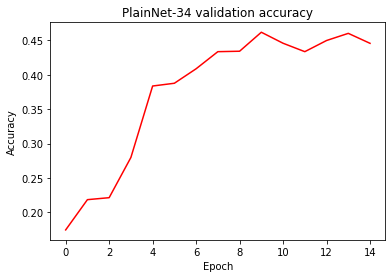

In [65]:
plt.plot(history_plain_34.history['val_accuracy'], 'r')
plt.title('PlainNet-34 validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

###5.1.2: ResNet-34

In [ ]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

In [71]:
history_resnet_34 = resnet_34.fit(
    ds32_train2,
    steps_per_epoch=int(ds32_info.splits['train[:90%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds32_info.splits['train[90%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds32_test2,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 51s 246ms/step - loss: 9.3601 - accuracy: 0.4510 - val_loss: 9.5089 - val_accuracy: 0.3907
Epoch 2/15
195/195 [==============================] - 49s 251ms/step - loss: 9.1417 - accuracy: 0.5273 - val_loss: 9.3940 - val_accuracy: 0.4299
Epoch 3/15
195/195 [==============================] - 48s 244ms/step - loss: 8.9615 - accuracy: 0.5837 - val_loss: 9.3937 - val_accuracy: 0.4354
Epoch 4/15
195/195 [==============================] - 47s 243ms/step - loss: 8.7483 - accuracy: 0.6570 - val_loss: 9.4233 - val_accuracy: 0.4439
Epoch 5/15
195/195 [==============================] - 48s 246ms/step - loss: 8.5332 - accuracy: 0.7303 - val_loss: 9.4685 - val_accuracy: 0.4479
Epoch 6/15
195/195 [==============================] - 48s 245ms/step - loss: 8.3074 - accuracy: 0.8065 - val_loss: 9.5074 - val_accuracy: 0.4613
Epoch 7/15
195/195 [==============================] - 52s 269ms/step - loss: 8.1237 - accuracy: 0.8658 - val_loss: 9.6998 - val_ac

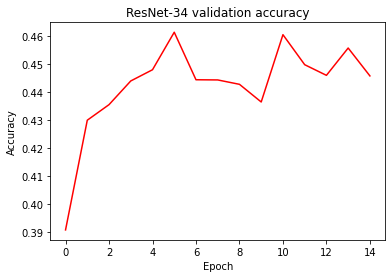

In [72]:
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.title('ResNet-34 validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

###5.1.3: 시각화

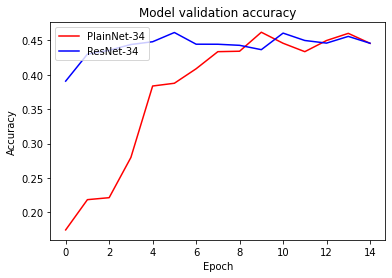

In [73]:
plt.plot(history_plain_34.history['val_accuracy'], 'r')
plt.plot(history_resnet_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['PlainNet-34', 'ResNet-34'], loc='upper left')
plt.show()

#6: 회고

* 논문을 토대로 ResNet-34 와 ResNet-50을 구현해 보았는데, 무척 어려웠다.
* Ablation Study를 통해서, ResNet의 성능을 평가할 수 있었다.
* ResNet 특징상, 다층에서의 성능이 좋으므로, 100층이상의 model로 추가시험해 볼만 할 거 같다.

# References

* https://github.com/KaimingHe/deep-residual-networks
* https://www.analyticsvidhya.com/blog/2021/08/how-to-code-your-resnet-from-scratch-in-tensorflow/
* https://blog.devgenius.io/resnet50-6b42934db431